# Online Social Network Analysis (Twitter)
---
The goal of this project is to explore social media platforms, recognize  the types of social networks formed on the platforms, gain hands-on experience on using APIs offered by the platforms and 3rd parties, experiment with collecting network data and perform analysis on the extracted data.

# 1. Data Collection

In [1]:
# Make all necessary imports
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import matplotlib.colors as mcolors
import time
import matplotlib as mpl

In [2]:
#  The bearer token is used for authenticating the twitter api
bearer_token = "******************YOUR_API_TOKEN********************************"

# Pass the bearer token to obtain an instance of the twitter api which can then be used to make calls
client = tweepy.Client(bearer_token=bearer_token)

In [3]:
#Get User Details
# Enter the name of the user you would like to run the analysis
lookupUser = client.get_user(username='Ferrari')
lookupUser

Response(data=<User id=2650413864 name=Ferrari username=Ferrari>, includes={}, errors=[], meta={})

In [4]:
#Get Recent Tweets
getTrendingTweets = client.get_users_tweets(id=lookupUser.data.id,max_results=5)

In [5]:
#Get Retweets
tweetVsRetweetData = {}
for tweet in getTrendingTweets.data:
    data = client.get_retweeters(id=tweet.id)
    if data != None:
        tweetVsRetweetData[tweet.id] = data

In [6]:
# Create a dataframe add and the trending tweets to it
tweetIds = []
for tweet in getTrendingTweets.data:
    tweetIds.append((lookupUser.data.id, tweet.id, lookupUser.data.username))
df = pd.DataFrame(columns=['source','target','SourceName'], data=tweetIds)
df

,source,target,SourceName
0,2650413864,1504851371329302528,Ferrari
1,2650413864,1504499170484404230,Ferrari
2,2650413864,1504412773215870988,Ferrari
3,2650413864,1504131864583446531,Ferrari
4,2650413864,1504126595371438080,Ferrari


In [9]:
# Add all the retweet data to the dataframes
retweetData = []
for tweetId in tweetVsRetweetData.keys():
    reTweets = tweetVsRetweetData[tweetId]
    if reTweets.data != None:
        for retweet in reTweets.data:
            retweetData.append((tweetId, retweet.id, retweet.name))
len(retweetData)

215

In [10]:
retweetDataFrame = pd.DataFrame(columns=['source','target','SourceName'], data=retweetData)
retweetDataFrame

,source,target,SourceName
0,1504851371329302528,1487139508608901121,Carlito
1,1504851371329302528,1504902646913806337,Leidivan Matos
2,1504851371329302528,1239274952647475202,Wallace
3,1504851371329302528,1470066651022385157,Čhåmpømy🫡
4,1504851371329302528,1297843935939887104,JACOB WELSH #ZoeyChristmas
...,...,...,...
210,1504126595371438080,366063241,Frans Xavier
211,1504126595371438080,1275507336405291012,Loucif Mohammed Walid
212,1504126595371438080,1408051027748786176,Anthony
213,1504126595371438080,1410921455135514626,日本連合


In [11]:
df = df.append(retweetDataFrame)

In [12]:
# Save the Data for offline use
df.to_csv('DiffusionNetwork.csv', encoding='utf-8', index=False)

# We are done with collecting data
# From here we can work offline therefore can clean the unused variables up
del retweetDataFrame,retweetData, tweetIds, tweetVsRetweetData, getTrendingTweets, lookupUser, client, bearer_token
del df

## 2. Data Visualization

In [13]:
# Reload the Data
df = pd.read_csv('DiffusionNetwork.csv') 
df

,source,target,SourceName
0,2650413864,1504851371329302528,Ferrari
1,2650413864,1504499170484404230,Ferrari
2,2650413864,1504412773215870988,Ferrari
3,2650413864,1504131864583446531,Ferrari
4,2650413864,1504126595371438080,Ferrari
...,...,...,...
215,1504126595371438080,366063241,Frans Xavier
216,1504126595371438080,1275507336405291012,Loucif Mohammed Walid
217,1504126595371438080,1408051027748786176,Anthony
218,1504126595371438080,1410921455135514626,日本連合


In [14]:
# Create a networkx graph from the dataframe with the given target and source
G = nx.from_pandas_edgelist(df, 'target', 'source', create_using=nx.DiGraph)
#G = nx.from_pandas_edgelist(df, 'target', 'source')
G

In [15]:
center = nx.center(G.to_undirected())

In [16]:
#Function to define the nodeSize for the plot
def defineWeight(n,v):
    if(n == center[0]):
        return v^3 * 1500
    else:
        return v^2 * 300

In [17]:
# Use the matplotlib library to plot the graph
def plotGraph(G):
    degrees = G.degree()
    n_color = np.asarray([degrees[n] for n in G.nodes()])
    # print(n_color)
    pos = nx.kamada_kawai_layout(G)
    f, ax = plt.subplots(figsize=(30, 30))
    plt.style.use('ggplot')
    plt.title("Diffusion Network")
    nodes = nx.draw_networkx_nodes(G, pos,
                                alpha=0.8, node_color=n_color, cmap='tab10', node_size=[defineWeight(n,v) for (n,v) in degrees])
    nodes.set_norm(mcolors.LogNorm())
    nx.draw_networkx_labels(G, pos, font_size=9, font_color='black')
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2,arrows=True)

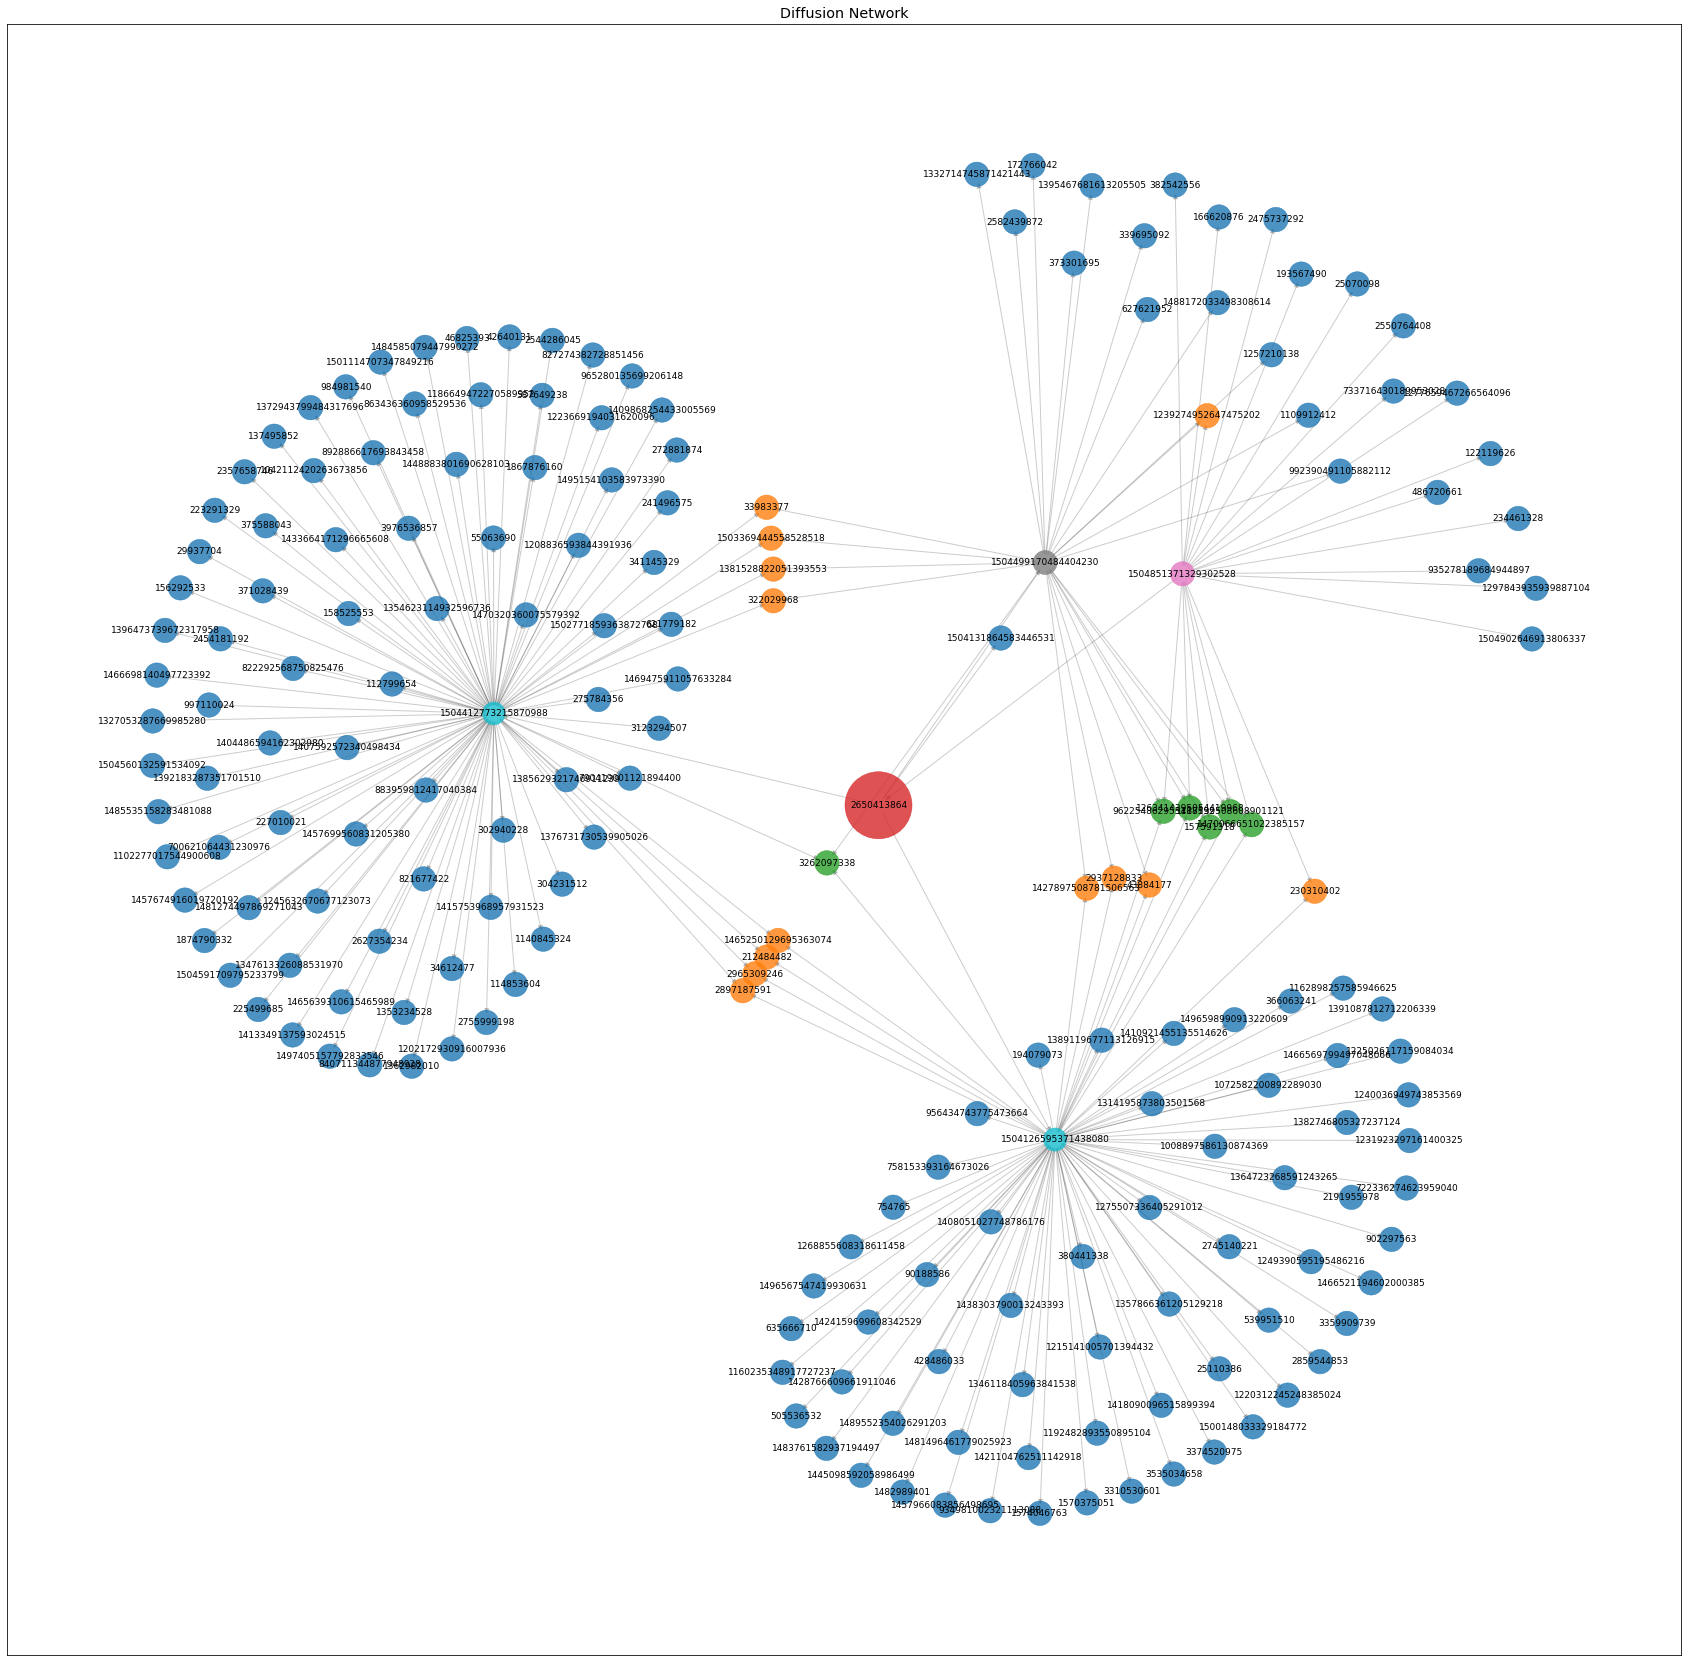

In [18]:
plotGraph(G.to_undirected())

## 3. Network Measures Calculation

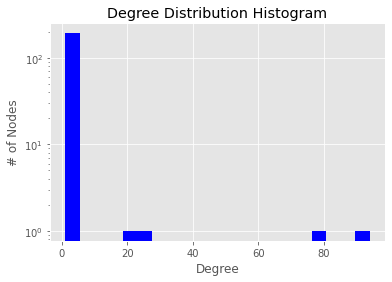

In [19]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)


# determine bins
# Freedman–Diaconis rule
'''
q25, q75 = np.percentile(degree_sequence, [.25, .75])
print(q25, q75)
bin_width = 2 * (q75 - q25) * len(degree_sequence) ** (-1/3)
print(bin_width)
bins = round((dmax - dmin) / bin_width)'''


bins = round(np.sqrt(sum(degree_sequence)))#Square-root choice

plt.hist(degree_sequence,bins,log=True, color = 'b')
plt.title('Degree Distribution Histogram')
plt.ylabel('# of Nodes')
plt.xlabel('Degree')
plt.show()

In [20]:
# These are our other network measures
degree_centrality = nx.degree_centrality(G)
degree_centrality
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweeness_centrality = nx.betweenness_centrality(G)
page_rank = nx.pagerank(G)

df = pd.DataFrame.from_dict(degree_centrality,orient='index',columns=['degree_centrality'])
df = df.join(pd.DataFrame.from_dict(in_degree_centrality,orient='index',columns=['in_degree_centrality']))
df = df.join(pd.DataFrame.from_dict(out_degree_centrality,orient='index',columns=['out_degree_centrality']))
df = df.join(pd.DataFrame.from_dict(betweeness_centrality,orient='index',columns=['betweeness_centrality']))
df = df.join(pd.DataFrame.from_dict(page_rank,orient='index',columns=['page_rank']))
df.head(10)

,degree_centrality,in_degree_centrality,out_degree_centrality,betweeness_centrality,page_rank
1504851371329302528,0.112821,0.107692,0.005128,0.000441,0.030390
2650413864,0.025641,0.025641,0.000000,0.000000,0.285653
1504499170484404230,0.133333,0.128205,0.005128,0.000449,0.030957
1504412773215870988,0.482051,0.476923,0.005128,0.002335,0.152448
1504131864583446531,0.005128,0.000000,0.005128,0.000000,0.002004
1504126595371438080,0.394872,0.389744,0.005128,0.001798,0.117817
1487139508608901121,0.015385,0.000000,0.015385,0.000000,0.002004
1504902646913806337,0.005128,0.000000,0.005128,0.000000,0.002004
1239274952647475202,0.010256,0.000000,0.010256,0.000000,0.002004
1470066651022385157,0.015385,0.000000,0.015385,0.000000,0.002004


In [21]:
df.to_csv("networkMeasures.csv");

Text(0.85, 0.95, 'node size = betweeness centrality')

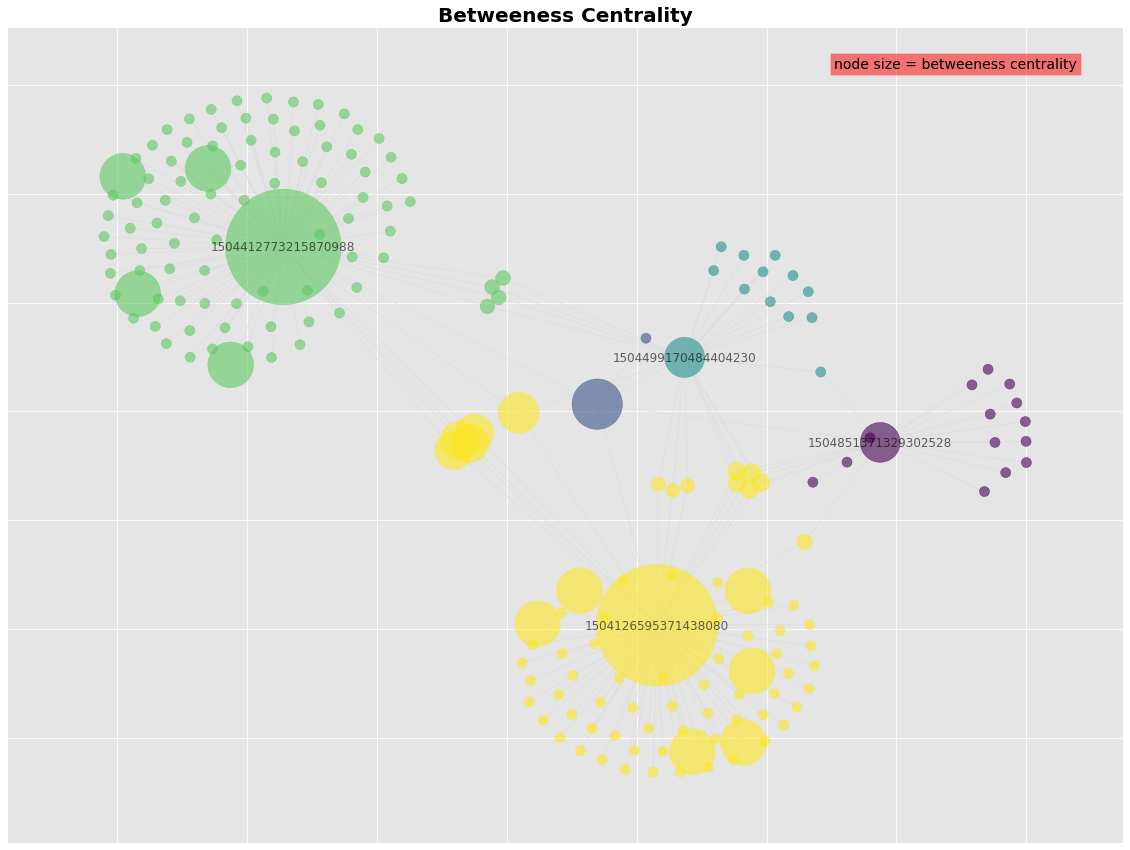

In [22]:
# Plot Betweeness centrality 


G = G.to_undirected()
# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]

labels = {}
for n in df[df['betweeness_centrality'] > 0.0001].index.tolist():
    labels[n]= n
nx.draw_networkx(
    H,
    pos=pos,
    labels=labels,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.6,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Betweeness Centrality", font)
ax.text(0.85,
    0.95,
    "node size = betweeness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    bbox=dict(facecolor='red', alpha=0.5),
    fontsize= 14)